## Parameter estimation

This notebook explains how to estimate the parameters for the water balance model that we developed during session 5.


In [1]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lmfit

In [2]:
# read the data from excel using pandas
df = pd.read_excel('data/water_balance_data.xlsx',
                   index_col=0,
                   parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample,delta_18O_sample,delta_2H_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.483474,20.401982,-4.32923,-16.581998
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.744956,NaN,NaN,NaN
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.896925,NaN,NaN,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN,NaN,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,2.668875,NaN,NaN,NaN


In [3]:
pan_factor = 1.2
Cl_0 = 20 # g/m^3 = mg/l
Cl_rain = 5 # g/m^3 = mg/l

df['P'] = df['area'] * df['rain'] / 1000.
df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
df['dV'] = -df['volume'].diff(periods=-1)
df['I'] = df['P'] - df['E'] - df['dV']

M_Cl_g = np.empty(len(df))
conc_Cl = np.empty(len(df))

P = df["P"].to_numpy()
I = df["I"].to_numpy()
V = df["volume"].to_numpy()
for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
    if i == 0: # First day
        M_Cl_g[0] = Vi * Cl_0
        conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
    else:
        M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
        conc_Cl[i] = M_Cl_g[i] / Vi

    dM_P = Cl_rain * Pi
    dM_I = conc_Cl[i] * Ii

df["conc_Cl"] = conc_Cl

Let's plot the calculated chloride concentrations, as well as the measured ones. The result isn't too bad, except that there appears to be a diverging trend in time. This will be dealt with in the next session.

<Axes: >

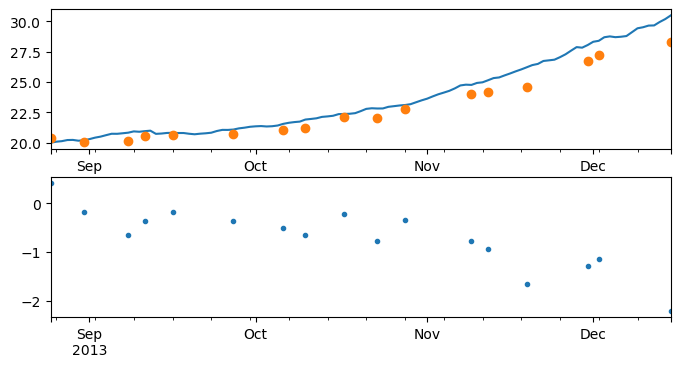

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(8,4))
df["conc_Cl"].plot(ax=axes[0])
df["Cl_sample"].plot(ax=axes[0], marker='o')

(df['Cl_sample'] - df['conc_Cl']).plot(ax=axes[1], marker='.')

## Estimate concentration parameters

The lmfit package can be used to estimate the pan factor and the chloride concentration of the rain. We use these steps for this:
1. Create a function to calculate the Chloride concentration given the two parameters: pan factor and chloride concentration.
2. Create an objective function in Python that will calculate the residuals from the parameters. This function will call the function in step 1.
3. Run the lmfit minimize function to find the optimal values

In [5]:
def get_conc_cl(pan_factor, Cl_rain):
    """ get the chloride concentration over time
    
    Parameters
    ----------
    pan_factor : float
        pan evaporation factor
    Cl_rain : float
        chloride concentration of the rain

    Returns
    -------
    df : pandas DataFrame
        dataframe with calculate concentration as a column    
    """
    Cl_0 = 20 # g/m^3 = mg/l

    df['P'] = df['area'] * df['rain'] / 1000.
    df['E'] = df['area'] * df['evaporation'] / (pan_factor) / 1000.
    df['dV'] = -df['volume'].diff(periods=-1)
    df['I'] = df['P'] - df['E'] - df['dV']

    M_Cl_g = np.empty(len(df))
    conc_Cl = np.empty(len(df))

    P = df["P"].to_numpy()
    I = df["I"].to_numpy()
    V = df["volume"].to_numpy()
    for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
        if i == 0: # First day
            M_Cl_g[0] = Vi * Cl_0
            conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
        else:
            M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
            conc_Cl[i] = M_Cl_g[i] / Vi

        dM_P = Cl_rain * Pi
        dM_I = conc_Cl[i] * Ii

    df["conc_Cl"] = conc_Cl

    return df

In [6]:
def obj_cl_compare(pars):
    """ objective function, compares calculated chloride concentration with 
    measurements.

    Parameters
    ----------
    pars : lmfit Parameters
        parameters with optimization settings
    
    Returns
    -------
    numpy array with differences measured - modelled concentrations
    """
    parvals = pars.valuesdict()
    pan_factor = parvals['pan_factor']
    Cl_rain = parvals['Cl_rain']

    df = get_conc_cl(pan_factor, Cl_rain)

    return (df['Cl_sample'] - df['conc_Cl']).dropna().values

In [7]:
parameters = lmfit.Parameters()
parameters.add('pan_factor', value=1.2, min=0.1, max=3.0)
parameters.add('Cl_rain', value=5.0, min=0.00001, max=20.0)
mini = lmfit.Minimizer(userfcn=obj_cl_compare,
                       calc_covar=True,
                       params=parameters)
result = mini.minimize(method="leastsq")
result

<Axes: >

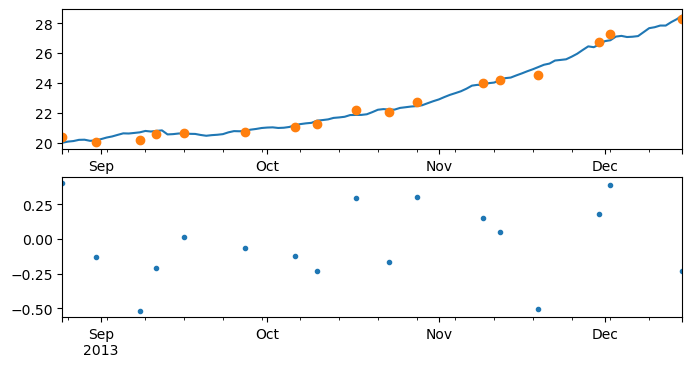

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8,4))
df = get_conc_cl(1.36618612, 4.52270303)
df["conc_Cl"].plot(ax=axes[0])
df["Cl_sample"].plot(ax=axes[0], marker='o')

(df['Cl_sample'] - df['conc_Cl']).plot(ax=axes[1], marker='.')